In [111]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import gym
import numpy as np
from functools import partial


from flax import linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt
from tqdm import tqdm

from RLenv import SimpleDeltaEnv

jax.config.update('jax_enable_x64',True)

In [112]:
# Define the model
class SimpleNN(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=64)
    self.dense2 = nn.Dense(features=30)

  def __call__(self, x):
    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    x = nn.softmax(x)
    return x

In [113]:
env = SimpleDeltaEnv()

model = SimpleNN()
key = jax.random.PRNGKey(0)
obs_shape = env.observation_space.shape[0]
x_sample = jax.random.uniform(key, (1, obs_shape))
params = model.init(jax.random.PRNGKey(1), x_sample)
optimiser = optax.adam(learning_rate=0.001)

In [114]:
# Create TrainState for managing parameters and optimizer state
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser
)

In [ ]:
print(f'{jnp.shape(my_state)} shape')
print(f'{jnp.shape(x_sample)} shape')

In [116]:
# Define the loss function (negative reward in RL)
def loss_fn(params, obs, action_taken, reward):
    
    logits = model.apply(params, obs)
    action_pred = logits[action_taken]  # Predicted Q-value for the taken action
 
    loss = jnp.mean((reward - action_pred) ** 2)  # Mean Squared Error loss
    
    return loss



# Define a single training step
@jax.jit
def train_step(state, obs, action_taken, reward):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, obs, action_taken, reward)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [117]:
import traceback

# Interaction with the environment
def run_episode(state, key, max_steps=100):
    obs, _ = env.reset()
    total_reward = 0
    
    all_actions = []
    all_rewards = []

    
    for _ in range(max_steps):
        
        obs = jnp.array(obs).reshape(1, -1)  # Reshape to match the input expected by the model
        logits = model.apply(state.params, obs)
        #action = np.random.choice(logits.shape[1], p=logits[0])
        
        key, subkey = jax.random.split(key)
        action = jax.random.choice(subkey, logits.shape[1], p=logits[0])
       
        # Take a step in the environment
        next_obs, reward, done, _, _ = env.step(int(action))
        total_reward += reward
        # Training step (we use the negative reward as a target for gradient update)
        
        #state, loss = train_step(state, obs, action, jnp.array(-reward, dtype=jnp.float32))
        #total_loss += loss
        # Print step-by-step training loss
        
        all_actions.append(action)
        all_rewards.append(-reward)         
       
        if done:
            break
        obs = next_obs
        
    # Compute loss after the episode
    all_actions = jnp.array(all_actions)
    all_rewards = jnp.array(all_rewards).reshape(-1, 1)  # Ensure shape consistency
    # Compute predictions for all actions taken
    obs = jnp.array(obs).reshape(1, -1)
    logits = model.apply(state.params, obs)
    action_preds = logits[all_actions]
    
    
    state, loss = train_step(state, obs, all_actions, all_rewards)
    
        
    return state, total_reward, loss #total_loss/max_steps

In [ ]:

# List to store loss values
losses = []

# Train the model over several episodes
n_episodes = 10
key = jax.random.PRNGKey(0)
pbar = tqdm(range(n_episodes))
for episode in pbar:
    key, subkey = jax.random.split(key)
    my_state, total_reward, total_loss = run_episode(my_state,subkey)
    losses.append(total_loss)
    if (episode+1) % 100 == 0:
        pbar.set_description(f"Episode {episode+1}: Total Reward = {total_reward}, Total loss = {total_loss}")
    #print(f"Episode {episode+1}: Total Reward = {total_reward}, Total loss = {total_loss}")
    

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss over episodes
plt.plot(range(n_episodes), losses, label='Loss')
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Average Loss per Episode Over Time')
plt.legend()
plt.show()


# REINFORCE inital attempt

In [15]:
#Imports
import jax
import jax.numpy as jnp
import flax.linen as nn

from tqdm import tqdm
import gym
import numpy as np
import matplotlib.pyplot as plt

import optax
from flax.training import train_state


from collections import Counter
import copy

# Import your custom environment (ensure it's in the same directory or install it as a package)
from RLenv import SimpleDeltaEnv

from RLenv import check_if_done


In [16]:
# Define the MLP policy model
class SimpleMLP(nn.Module):
    N_features: int  # Define N_features as an input variable
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=self.N_features)(x)  # Output layer (number of actions)
        x = nn.softmax(x)             # Softmax to convert logits to action probabilities
        return x


In [17]:

# Create the environment
env = SimpleDeltaEnv(N_fibres=10, REPEAT_PEN=25)
envInit = copy.deepcopy(env)

# Initialise the model and optimiser
model = SimpleMLP(N_features=env.N_fibres)
key = jax.random.PRNGKey(0)
obs_shape = env.observation_space.shape[0]
x_sample = jax.random.uniform(key, (1, obs_shape))  # Single sample for initializing the model
params = model.init(jax.random.PRNGKey(1), x_sample)
optimiser = optax.adam(learning_rate=0.001)

# Create TrainState for managing parameters and optimizer state
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser
)

In [18]:

#function to plot the agent progress and print out a summary
def plot_agent_progress(actions, coords, N_fibs=3, plotting=False):
    print(f'Actions {actions}')
    action_list = jnp.asarray(actions)
    action_list = action_list.tolist()
    action_set = set(action_list)
    unmoved = set(np.arange(N_fibs)).difference(action_set)
    moved = set(np.arange(N_fibs)).intersection(action_set)
    print(f'N Moved fibres: {len(moved)} N Unmoved fibres {len(unmoved)}')
    print(f'N Moved fibres: {moved} N Unmoved fibres {unmoved}')
    
    
    start_coords = np.array([coord[0] for coord in coords])
    end_coords = np.array([coord[1] for coord in coords])
    
    # Get the frequency of each action to adjust the point size
    action_counts = Counter(action_list)

    # Create a size array where size increases with frequency of actions
    sizes = np.array([action_counts[action] * 5 for action in action_list])

    # Create a colormap based on the order in the list
    colors = np.linspace(0, 1, len(action_list))
    print(f'Len colours {len(colors)}')
    
    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Scatter plot of coordinates
    # Polar plot for start coordinates
    axs[0] = plt.subplot(211, polar=True)
    
    for index, item in enumerate(actions):
        axs[0].scatter(end_coords[item, 1], end_coords[item, 0], c=colors[item], s=sizes[item], cmap='viridis', alpha=0.7, label='Start Coords' if item == 0 else "")
    
    axs[0].set_title('Polar Plot of Start and End Coordinates')
    #axs[0].legend()

    # Histogram of actions
    axs[1].hist(actions, edgecolor='black')
    axs[1].set_xlabel('Action Taken')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Actions')

    # Show the plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    plt.show()
    return


In [19]:

# Compute discounted rewards
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    return jnp.array(discounted_rewards)

# Define the loss function (Policy Gradient)
@jax.jit
def loss_fn(params, obs, actions, discounted_rewards):
    logits = model.apply(params, obs)
    log_probs = jnp.log(logits[jnp.arange(logits.shape[0]), actions])  # Log-probabilities of the selected actions
    loss = -jnp.mean(log_probs * discounted_rewards)  # Policy Gradient loss
    return loss

# Define a single training step
@jax.jit
def train_step(state, obs, actions, discounted_rewards):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, obs, actions, discounted_rewards)
    state = state.apply_gradients(grads=grads)
    return state, loss


# Interaction with the environment
def run_episode(state, key,max_steps=100, gamma=0.99, plotting=False):
    #obs, _ = env.reset()
    
    env.field = copy.deepcopy(envInit.field)  
    env.fibre_coords = copy.deepcopy(envInit.fibre_coords)  
    env.W = copy.deepcopy(envInit.W)  
    env.observation = copy.deepcopy(envInit.observation) 
     
    # Initialize observation at the start of the episode
    obs = copy.deepcopy(env.observation)
    
    # print(f'Start of episode!: {env.fibre_coords} \n {envInit.fibre_coords} \n')
    # print(f'Start of obs: {obs}')
    
    
    total_reward = 0
    
    all_obs = []
    all_actions = []
    all_rewards = []
    
    for step in range(max_steps):
        # if step ==0:
        #     print(f'Initial fibre coords {env.fibre_coords} \n')
            
        obs = jnp.array(obs).reshape(1, -1)
        logits = model.apply(state.params, obs)
        
        #key, subkey = jax.random.split(key)
        key, inKey = jax.random.split(key)
        action = jax.random.choice(inKey, logits.shape[1], p=logits[0])
        
        next_obs, reward, done, _, _ = env.step(int(action))
        total_reward += reward
        
        all_obs.append(obs)
        all_actions.append(action)
        all_rewards.append(reward)
        
        if done:
            # print(f'DONE CONDITION HIT \n')
            # print(f'end of episode!: {env.fibre_coords} \n {envInit.fibre_coords} \n')
            # print(f'end of episode obs: {obs} \n')
            # print(f'Actions taken {all_actions}')
            
            break
        obs = next_obs
        
        
    
    # Convert lists to arrays for training
    all_obs = jnp.vstack(all_obs)
    all_actions = jnp.array(all_actions)
    discounted_rewards = compute_discounted_rewards(all_rewards, gamma)
    
    # Update the model using REINFORCE
    state, loss = train_step(state, all_obs, all_actions, discounted_rewards)
    
    if step == max(range(max_steps)) and plotting:
        coords = env.fibre_coords.reshape(-1, 4)
        coords = [[(row[0], row[1]), (row[2], row[3])] for row in coords]
        plot_agent_progress(all_actions, coords)
        
    
    return state, total_reward, loss, step, all_actions, done

# Train the model over several episodes
n_episodes = 10000
_losses = []
_epLength = []
key = jax.random.PRNGKey(0)
avLength = 0
_avLength = []

pbar = tqdm(range(n_episodes))
for episode in pbar:
    key, inKey = jax.random.split(key)

    if episode == n_episodes-1 or episode == 0:
        my_state, total_reward, ep_loss, step, ep_actions, done = run_episode(my_state,inKey, plotting=True)
        #print(f'Episode {episode} Done? {done}, actions {ep_actions}')
    else:
        my_state, total_reward, ep_loss, step, ep_actions, done = run_episode(my_state,inKey, plotting=False)
        #print(f'Episode {episode} Done? {done}, actions {ep_actions}')
   
    _losses.append(ep_loss)
    _epLength.append(step)
    
    if episode<10:
        avLength = jnp.mean(jnp.array(_epLength))
    else :
        avLength = jnp.mean(jnp.array(_epLength)[-10:])
    
    _avLength.append(avLength)
    
    pbar.set_description(f"Episode {episode} |  Average Ep Length = {avLength} | Total Reward = {total_reward} | Done? {done}")
    


Episode 12 |  Average Ep Length = 40.10000228881836 | Total Reward = -261.31694652904065 | Done? True:   0%|          | 13/10000 [00:08<1:53:39,  1.46it/s]


KeyboardInterrupt: 

In [12]:
### Use this to add in curriculum learning
#(episode % max_N_fibres) + 1

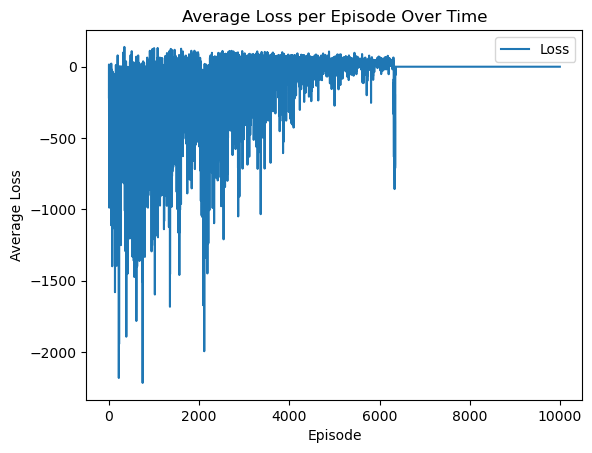

In [13]:
# Plot the loss over episodes
plt.plot(range(len(_losses)), _losses, label='Loss')
plt.xlabel('Episode')
#plt.yscale('log')
plt.ylabel('Average Loss')
plt.title('Average Loss per Episode Over Time')
plt.legend()
plt.show()


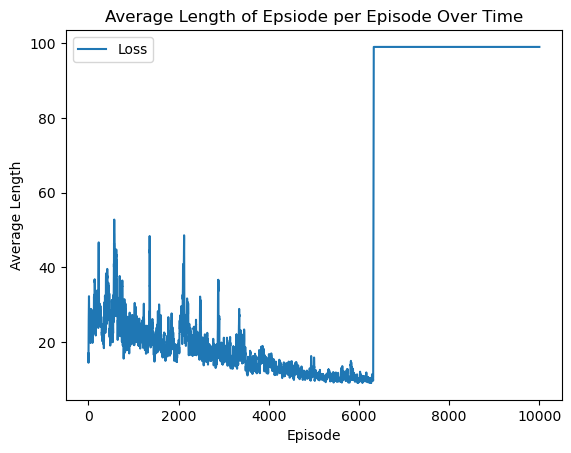

In [14]:
# Plot the loss over episodes
plt.plot(range(n_episodes), _avLength, label='Loss')
plt.xlabel('Episode')
plt.ylabel('Average Length')
plt.title('Average Length of Epsiode per Episode Over Time')
plt.legend()
plt.show()


In [9]:
_, total_reward, ep_loss, step, ep_actions, done = run_episode(my_state,inKey, plotting=True)

Actions: [Array(9, dtype=int32), Array(7, dtype=int32), Array(2, dtype=int32), Array(3, dtype=int32), Array(7, dtype=int32), Array(0, dtype=int32), Array(1, dtype=int32), Array(7, dtype=int32), Array(7, dtype=int32), Array(9, dtype=int32), Array(9, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(9, dtype=int32), Array(1, dtype=int32), Array(3, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32), Array(3, dtype=int32), Array(5, dtype=int32), Array(0, dtype=int32), Array(8, dtype=int32), Array(6, dtype=int32), Array(0, dtype=int32), Array(1, dtype=int32), Array(0, dtype=int32), Array(4, dtype=int32)]
N Moved fibres: 10, N Unmoved fibres: 20


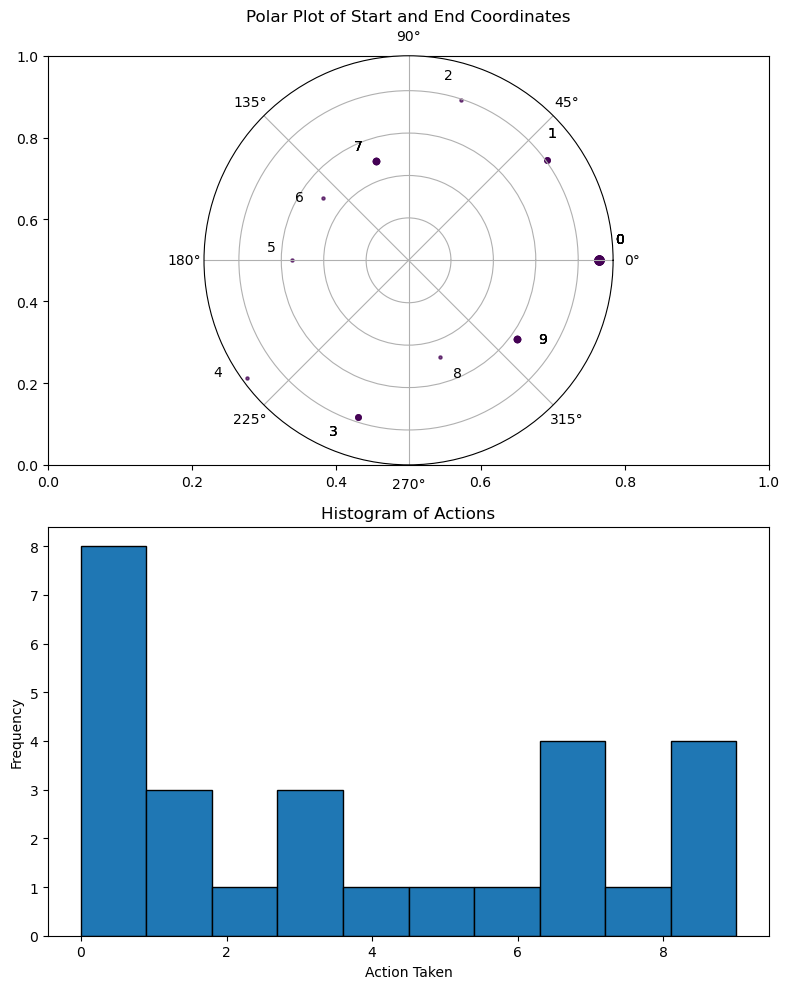

Total Reward: -465.62653894674787
Number of Steps: 27


In [10]:
### Code to track what an agent is doing over a single episode

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from collections import Counter

# Assuming model, env, and trained state are already initialized

# Function to plot the agent's progress and print a summary of the actions
def plot_agent_progress(actions, coords):
    
    action_list = jnp.asarray(actions)
    action_list = action_list.tolist()
    print(f'Actions: {action_list}')
    action_set = set(action_list)
    unmoved = set(np.arange(30)).difference(action_set)
    moved = set(np.arange(30)).intersection(action_set)
    print(f'N Moved fibres: {len(moved)}, N Unmoved fibres: {len(unmoved)}')
    
    start_coords = np.array([coord[0] for coord in coords])
    end_coords = np.array([coord[1] for coord in coords])
    
    # Get the frequency of each action
    action_counts = Counter(action_list)
    print(f'Action counts: {action_counts}')

    # Create a size array where size increases with frequency of actions
    sizes = np.array([action_counts[action] * 5 for action in action_list])

    # Create a colormap based on the order in the list
    colors = np.linspace(0, 1, len(action_list))
    
    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Polar plot for start and end coordinates
    axs[0] = plt.subplot(211, polar=True)
    
    offset = 0.1  # Offset for text labels
    for index, action in enumerate(action_list):
        axs[0].scatter(end_coords[action, 1], end_coords[action, 0], c=colors[index], s=sizes[index], cmap='viridis', alpha=0.7)
        # Calculate the offset position for the text labels
        theta, r = end_coords[action, 1], end_coords[action, 0]
        text_theta = theta + offset if theta < np.pi else theta - offset  # Adjust for polar coordinates
        text_r = r + offset

        # Add action numbers as text labels at the offset position
        axs[0].text(text_theta, text_r, str(action), fontsize=10, ha='center', va='center', color='black')

    

    axs[0].set_title('Polar Plot of Start and End Coordinates')
    axs[0].set_yticklabels([])

    # Histogram of actions
    axs[1].hist(actions, edgecolor='black')
    axs[1].set_xlabel('Action Taken')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Actions')

    plt.tight_layout()
    plt.show()

# Function to run a single episode using the trained model
def run_single_episode(state, env, key, max_steps=100, plotting=True):
    obs, _ = env.reset()
    total_reward = 0
    all_obs = []
    all_actions = []
    all_rewards = []

    for step in range(max_steps):
        obs = jnp.array(obs).reshape(1, -1)
        logits = model.apply(state.params, obs)

        # Sample an action based on the trained policy
        key, subkey = jax.random.split(key)
        action = jax.random.choice(subkey, logits.shape[1], p=logits[0])

        next_obs, reward, done, _, _ = env.step(int(action))
        total_reward += reward

        all_obs.append(obs)
        all_actions.append(action)
        all_rewards.append(reward)

        if done:
            break
        obs = next_obs

    # Print the summary and plot the actions
    if plotting:
        coords = env.fibre_coords.reshape(-1, 4)
        coords = [[(row[0], row[1]), (row[2], row[3])] for row in coords]
        plot_agent_progress(all_actions, coords)

    print(f'Total Reward: {total_reward}')
    print(f'Number of Steps: {len(all_actions)}')
    return all_actions, total_reward

# Run the single episode with plotting
key = jax.random.PRNGKey(0)
actions, reward = run_single_episode(my_state, env, key, plotting=True)


# Reinforce with split episode training
---


In [ ]:
#Imports
import jax
import jax.numpy as jnp
import flax.linen as nn

from tqdm import tqdm
import gym
import numpy as np
import matplotlib.pyplot as plt

import optax
from flax.training import train_state


from collections import Counter
import copy

# Import your custom environment (ensure it's in the same directory or install it as a package)
from RLenv import SimpleDeltaEnv

from RLenv import check_if_done


In [ ]:
# Define the MLP policy model
class SimpleMLP(nn.Module):
    N_features: int  # Define N_features as an input variable
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=64)(x)  # First hidden layer with 64 units
        x = nn.gelu(x)                # Activation function
        x = nn.Dense(features=self.N_features)(x)  # Output layer (number of actions)
        x = nn.softmax(x)             # Softmax to convert logits to action probabilities
        return x


In [ ]:

# Create the environment
env = SimpleDeltaEnv(N_fibres=10, REPEAT_PEN=25)
envInit = copy.deepcopy(env)

# Initialise the model and optimiser
model = SimpleMLP(N_features=env.N_fibres)
key = jax.random.PRNGKey(0)
obs_shape = env.observation_space.shape[0]
x_sample = jax.random.uniform(key, (1, obs_shape))  # Single sample for initializing the model
params = model.init(jax.random.PRNGKey(1), x_sample)
optimiser = optax.adam(learning_rate=0.001)

# Create TrainState for managing parameters and optimizer state
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser
)

In [ ]:

# Compute discounted rewards
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    return jnp.array(discounted_rewards)

# Define the loss function (Policy Gradient)
@jax.jit
def loss_fn(params, obs, actions, discounted_rewards):
    logits = model.apply(params, obs)
    log_probs = jnp.log(logits[jnp.arange(logits.shape[0]), actions])  # Log-probabilities of the selected actions
    loss = -jnp.mean(log_probs * discounted_rewards)  # Policy Gradient loss
    return loss

# Define a single training step
@jax.jit
def train_step(state, obs, actions, discounted_rewards):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, obs, actions, discounted_rewards)
    state = state.apply_gradients(grads=grads)
    return state, loss


# Interaction with the environment
def run_episode(state, key,max_steps=100, gamma=0.99, plotting=False):
    #obs, _ = env.reset()
    
    env.field = copy.deepcopy(envInit.field)  
    env.fibre_coords = copy.deepcopy(envInit.fibre_coords)  
    env.W = copy.deepcopy(envInit.W)  
    env.observation = copy.deepcopy(envInit.observation) 
     
    # Initialize observation at the start of the episode
    obs = copy.deepcopy(env.observation)
    
    total_reward = 0
    
    all_obs = []
    all_actions = []
    all_rewards = []
    
    for step in range(max_steps):
        # if step ==0:
        #     print(f'Initial fibre coords {env.fibre_coords} \n')
            
        obs = jnp.array(obs).reshape(1, -1)
        logits = model.apply(state.params, obs)
        
        #key, subkey = jax.random.split(key)
        key, inKey = jax.random.split(key)
        action = jax.random.choice(inKey, logits.shape[1], p=logits[0])
        
        next_obs, reward, done, _, _ = env.step(int(action))
        total_reward += reward
        
        all_obs.append(obs)
        all_actions.append(action)
        all_rewards.append(reward)
        
        if done:
            # print(f'DONE CONDITION HIT \n')
            # print(f'end of episode!: {env.fibre_coords} \n {envInit.fibre_coords} \n')
            # print(f'end of episode obs: {obs} \n')
            # print(f'Actions taken {all_actions}')
            
            break
        obs = next_obs
        
        
    
    # Convert lists to arrays for training
    all_obs = jnp.vstack(all_obs)
    all_actions = jnp.array(all_actions)
    discounted_rewards = compute_discounted_rewards(all_rewards, gamma)
    
    # Update the model using REINFORCE
    state, loss = train_step(state, all_obs, all_actions, discounted_rewards)
    
    if step == max(range(max_steps)) and plotting:
        coords = env.fibre_coords.reshape(-1, 4)
        coords = [[(row[0], row[1]), (row[2], row[3])] for row in coords]
        plot_agent_progress(all_actions, coords)
        
    
    return state, total_reward, loss, step, all_actions, done

# Train the model over several episodes
n_episodes = 10000
_losses = []
_epLength = []
key = jax.random.PRNGKey(0)
avLength = 0
_avLength = []

pbar = tqdm(range(n_episodes))
for episode in pbar:
    key, inKey = jax.random.split(key)

    if episode == n_episodes-1 or episode == 0:
        my_state, total_reward, ep_loss, step, ep_actions, done = run_episode(my_state,inKey, plotting=True)
        #print(f'Episode {episode} Done? {done}, actions {ep_actions}')
    else:
        my_state, total_reward, ep_loss, step, ep_actions, done = run_episode(my_state,inKey, plotting=False)
        #print(f'Episode {episode} Done? {done}, actions {ep_actions}')
   
    _losses.append(ep_loss)
    _epLength.append(step)
    
    if episode<10:
        avLength = jnp.mean(jnp.array(_epLength))
    else :
        avLength = jnp.mean(jnp.array(_epLength)[-10:])
    
    _avLength.append(avLength)
    
    pbar.set_description(f"Episode {episode} |  Average Ep Length = {avLength} | Total Reward = {total_reward} | Done? {done}")
    
